In [1]:
import torch 
import numpy as np
import collections
import time
import pickle 
from tqdm import tqdm

import sys
import os

os.environ['CUDA_VISIBLE_DEVICES']='2'

sys.path.append('engine/')
sys.path.append('funcs/')
sys.setrecursionlimit(10000)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

from Model import *
from eval_funcs import *
from plot_funcs import *
from utils import *
from csv_utils import *
from psf_fit_funcs import *
from tifffile import *
from IPython.display import display, clear_output

data_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepstorm/datasets/'

In [2]:
images = imread(data_folder+'/SMLM_REAL/tubulin-3D/Tubulin-A647-3D-BEADS-as-stacks.tif').astype(config.floatX); modality = 'AS'
images = images[:,320:,140:332]
backg,_ = get_bg_stats(images)

true_locs = None

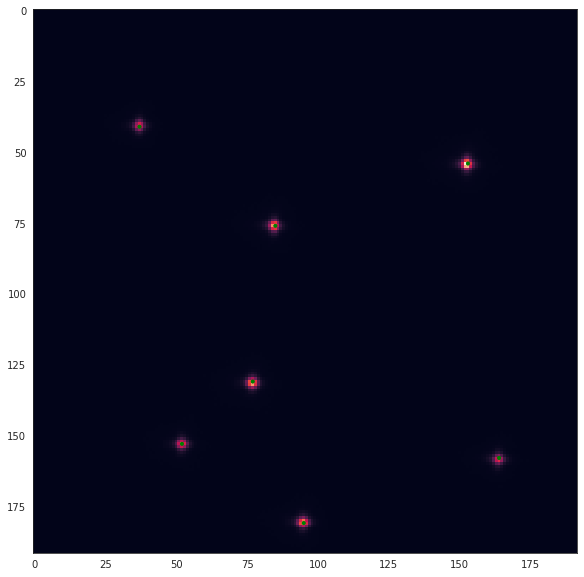

In [3]:
zero_ind = 170 # Sets the image which is considered to be in the focus plane. This frame is then used to perform an initial peak finding to dected all beads. 
z_step = 10 # Set the step size (in nano meter) and the maximum range that is used for PSF fitting
z_range = 600

peaks = get_peaks(images[zero_ind],threshold=2000,min_distance=10, double_helix='DH' in modality)

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(images[zero_ind])

for x,y in zip(np.array(peaks)[:,0],np.array(peaks)[:,1]):
    circ = plt.Circle((x,y), radius=0.3, color='g', fill=False, lw=2)
    ax.add_patch(plt.Circle((x,y), radius=0.3, color='g', fill=False, lw=2))
    ax.add_patch(plt.Circle((x,y), radius=0.3, color='g', fill=False, lw=2))

In [4]:
z_vals = np.arange(-z_range,z_range+1,z_step)
images = images[zero_ind-z_range//10:zero_ind+z_range//10]

In [5]:
n_beads = len(peaks)

signal = (images-backg).sum(-1).sum(-1)
discrete_locs = np.zeros_like(images[:1])

for xy in peaks:
    discrete_locs[0,int(xy[1]),int(xy[0])] = 1
peaks = np.array(discrete_locs[0].nonzero()).T[:,::-1]

ints = gpu(np.mean(signal)/1000/n_beads * np.ones([1,n_beads]))
xy_offsets = gpu(np.zeros([1,2,n_beads]))

scaled_images = (images-backg)/np.array(signal,ndmin=3).T * signal.mean() + backg

if true_locs is not None:
    true_locs = sort_true_locs(true_locs, peaks)

In [6]:
psf_params = {'om_0':4.11, 'c_x':2.41, 'c_y':-0.24, 'd':2.33, 'z_scale':6}
psf_params['modality'] = 'ASTIG_3D'

psf_params['beads_fit'] = True
psf_params['scale'] = 100.
           
mgen = LikelihoodModel(psf_params)

mgen.XY = torch.nn.Parameter(xy_offsets)
mgen.I = torch.nn.Parameter(ints/psf_params['scale'])
mgen.ll_pars = {'backg': backg}

mgen.lr = 0.03
mgen.batch_size = 10
mgen.n_samples = 1

set_optimizers(mgen, mgen.lr)

mgen.col_dict = {}
mgen.col_dict['cost_hist'] = collections.OrderedDict([])

In [7]:
iter_count = 0
print_freq = 100

costs = []

if true_locs is not None: get_rmses(mgen, peaks, true_locs, print_output=True)

for e in range(100):
    
    clear_output(wait=True)
    
    Iterator = StormIterator(print_freq, mgen.batch_size, scaled_images, z_vals/100)

    cost = 0
    for img, zo in Iterator:
        cost += train_beads(mgen, img[:,None], discrete_locs.repeat(mgen.batch_size,0), zo)

    cost /= print_freq
    mgen.col_dict['cost_hist'][mgen._iter_count] = cpu(cost)
    
    display(str(mgen._iter_count) + ': ' + str(cpu(cost)))

'10000: -150027.72'

In [8]:
recs = mgen.genfunc(gpu(discrete_locs.repeat(len(z_vals/100),0)),[mgen.XY,mgen.I,gpu(z_vals/100)], add_wmap=True) + backg
recs = cpu(recs)

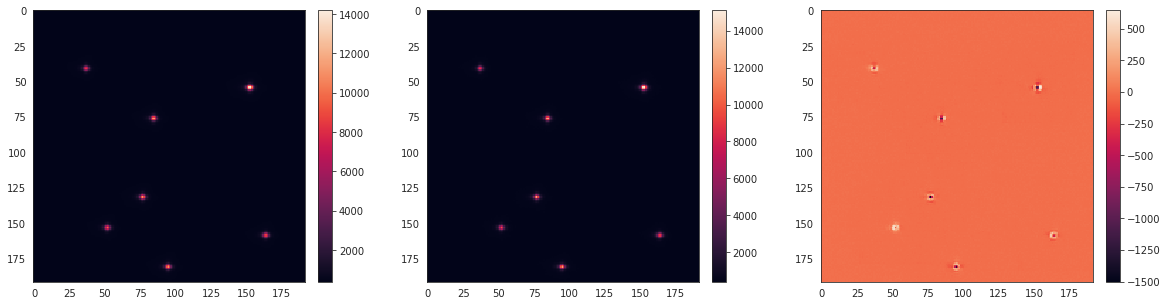

In [9]:
# Plots the reconstruction provided by the fitted model, the corresponding image and the difference between the two.

n = 55
f, axes = plt.subplots(1,3,figsize=(20,5))
plt1 = axes[0].imshow(recs[n])
plt2 = axes[1].imshow(scaled_images[n])
plt3 = axes[2].imshow(recs[n]-scaled_images[n])

plt.colorbar(plt1, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(plt2, ax=axes[1], fraction=0.046, pad=0.04)
plt.colorbar(plt3, ax=axes[2], fraction=0.046, pad=0.04)

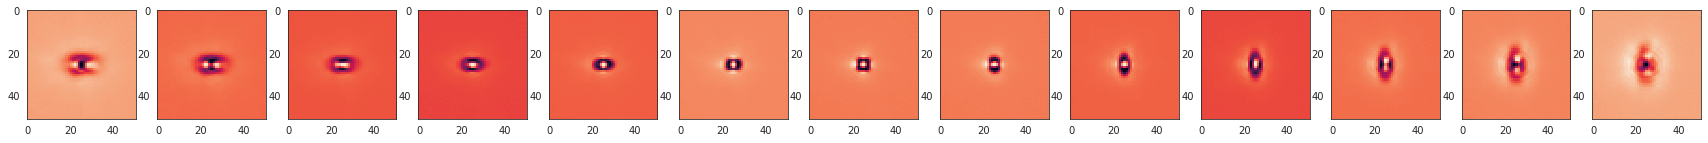

In [10]:
# Plots the fitted pixel maps that account for the difference between the true and the parametric bead function. 

plt.figure(figsize=(30,10))
for i in range(1,len(mgen.w_map)+1):
    plt.subplot(1,len(mgen.w_map),i)
    plt.imshow(cpu(mgen.w_map[i-1]))

In [11]:
# Stores the fitted parameters so they can be used to train a DECODE model

save_dict = {}
save_dict['w_map'] = mgen.w_map
save_dict['psf_params'] = mgen.psf_pars
save_dict['gen_model'] = mgen
save_dict['wobble'] = [0,0]
save_dict['costs'] = costs

with open('psf_real.pkl', 'wb') as f:
    pickle.dump(save_dict, f)